# **TRANSFER LEARNING IMPLEMENTATION ON IMAGE RECOGNITION OF INDONESIAN TRADITIONAL HOUSES**

Author By : [R Arif Firmansah](http://readonearif.github.io/)

Berikut adalah pembangunan model untuk aplikasi image recognition pada citra rumah adat indonesia dengan alogartima TRansfer learning convolution neural network dengan menggunakan model VGG16, MobileNetV2, Resnet50 dan Xception.

semua file dokumentasi project dapad dilihat pada [Repository ini](https://github.com/RArifF/TransfLearningRumahAdat),
data didapatkan dengan teknik image scrapper dari internet dan model terbaik yang didapat adalah 9.7 % dengan transfer learning model Resnet50

# 1. LOADING LIBRARY

In [ ]:
import pandas as pd                                               
pd.set_option('display.max_columns', None)                               
pd.set_option('display.max_colwidth', None)                              
pd.set_option('display.max_rows', None)                             
pd.set_option('display.float_format', lambda x: '%.3f' % x)         
#-------------------------------------------------------------------------------------------------------------------------------
import numpy as np                                                  
#-------------------------------------------------------------------------------------------------------------------------------
import matplotlib.pyplot as plt                                     
from matplotlib.pylab import rcParams                                                                              
import seaborn as sns                                               
#set seaborn plotting aesthetics
sns.set(style='whitegrid')
%matplotlib inline  

In [ ]:
import tensorflow as tf
import keras

import os
from pathlib import Path
from tensorflow.keras.utils import get_file
import glob

from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

# 2. IMPORT DATASET 

dataset didapatkan dengan applikasi python untuk image scrapper dari internet notebook python bisa dilihat [Notebook Image Scrapper](https://colab.research.google.com/drive/14QlR_xIt48ShEQA7kTeHxiOYfRjxPc_d?usp=sharing).

In [ ]:
# 
from tensorflow.keras.utils import get_file


data_dir = '/kaggle/input/rumah-adat/rumah_adat'
directory = Path(data_dir)

In [ ]:
image_count = len(list(directory.glob('*/*.jpg')))
print('Total number of images in the dataset are:', image_count)

Total image Rumah adat yang didapat dari internet hanya berjumlah 3919 gambar,
jumlah terserbut tidak cuku bersar untuk proses image recognition

In [ ]:
# checking the directory where the images are, to understand its structure
os.listdir(directory)

['honai', 'tongkonan', 'gadang', 'joglo', 'panjang']

In [ ]:
img_height = 224
img_width = 224
batch_size = 32
seed = 42

In [ ]:
from tensorflow.keras.utils import image_dataset_from_directory as idfd

In [ ]:
train_ds = idfd(
    directory,
    shuffle = True,
    label_mode = 'categorical',
    validation_split = 0.4,
    subset = 'training',
    seed=seed,
    image_size = (img_height, img_width),
    batch_size = batch_size
)

Found 3919 files belonging to 5 classes.
Using 2352 files for training.


In [ ]:
val_ds = idfd(
    directory,
    shuffle = True,
    label_mode = 'categorical',
    validation_split = 0.4,
    subset = 'validation',
    seed=seed,
    image_size = (img_height, img_width),
    batch_size = batch_size
)

Found 3919 files belonging to 5 classes.
Using 1567 files for validation.


In [ ]:
class_names = train_ds.class_names
print('List of classes classes:',class_names)

num_classes = len(class_names)
print('Number of neurons in output layer:',num_classes)

List of classes classes: ['gadang', 'honai', 'joglo', 'panjang', 'tongkonan']
Number of neurons in output layer: 5


#### Sample Images

In [ ]:
plt.figure(figsize=(15, 15))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        labn = labels[i].numpy().astype('uint8')
        label = np.where(labn == 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(label)
        plt.axis("off")

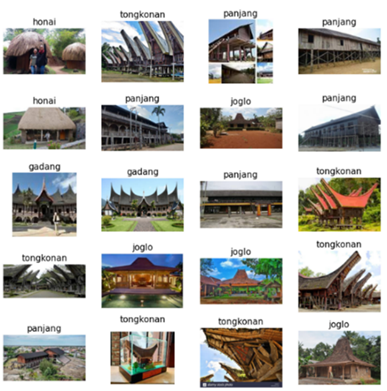![image.png]()

# 3. PREPROCESING DATA

In [ ]:
print('Memeriksa gambar dan label batch dalam hal ukurannya')

for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 224, 224, 3)
(32, 5)

In [ ]:
# taking a sample batch and noting the number of chanels
num_channels = image_batch[0].ndim
print('Number of channels:', num_channels)

Number of channels: 3


In [ ]:
val_batches = tf.data.experimental.cardinality(val_ds)
test_ds = val_ds.take(val_batches // 3)
val_ds = val_ds.skip(val_batches // 3)

In [ ]:
print('Number of validation batches: %d' % tf.data.experimental.cardinality(val_ds))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_ds))

Number of validation batches: 33
Number of test batches: 16


## 3.1 RESCALING LAYER

In [ ]:
rescale = tf.keras.Sequential([
  layers.Rescaling(1./255)
])

## 3.2. AUGMENTATION LAYER

In [ ]:
augment = tf.keras.Sequential(
  [
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.1),
  ]
)

# 4. MODELING TRANSFER LEARNING

## 4.1. MAKE MATRIX ACCURACY
Membuat variable untuk storing history akurasi, validasi, loss dan recall

In [ ]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import Precision, Recall

In [ ]:
metrics = [
    'accuracy',
    Precision(name='precision'),
    Recall(name='recall')
]

In [ ]:
def evolution(model, epochs):
    epochs = range(1,epochs+1)
    
    plt.figure(figsize=(20, 25))
    
    plt.subplot(4, 2, 1)
    loss_train = model.history['loss']
    loss_val = model.history['val_loss']
    plt.plot(epochs, loss_train, 'g', label='Training loss')
    plt.plot(epochs, loss_val, 'b', label='validation loss')
    plt.title('Loss Function Evolution')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    
    plt.subplot(4, 2, 2)
    accuracy_train = model.history['accuracy']
    accuracy_val = model.history['val_accuracy']
    plt.plot(epochs, accuracy_train, 'g', label='Training accuracy')
    plt.plot(epochs, accuracy_val, 'b', label='validation accuracy')
    plt.title('Accuracy Function Evolution')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()


    plt.subplot(4, 2, 3)
    precision_train = model.history['precision']
    precision_val = model.history['val_precision']
    plt.plot(epochs, precision_train, 'g', label='Training precision')
    plt.plot(epochs, precision_val, 'b', label='validation precision')
    plt.title('Precision Function Evolution')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()



    plt.subplot(4, 2, 4)
    recall_train = model.history['recall']
    recall_val = model.history['val_recall']
    plt.plot(epochs, recall_train, 'g', label='Training recall')
    plt.plot(epochs, recall_val, 'b', label='validation recall')
    plt.title('Recall Function Evolution')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
  

    return()

## 4.2 CNN BASIC

In [ ]:
from tensorflow.keras.layers import Rescaling, Flatten, Conv2D, Dense, MaxPooling2D, BatchNormalization, Dropout, Input

In [ ]:
cnn_model1 = Sequential(
[
    Input(shape= (img_height, img_width, num_channels)),
    augment,
    rescale,
    Conv2D(16, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Conv2D(32, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Conv2D(64, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Flatten(),
    Dense(128, activation='relu'),
    layers.Dense(num_classes, activation = 'softmax')
])

In [ ]:
cnn_model1.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics= metrics)

print(cnn_model1.summary())

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_1 (Sequential)    (None, 224, 224, 3)       0         
_________________________________________________________________
sequential (Sequential)      (None, 224, 224, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 224, 224, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 112, 112, 16)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 112, 112, 32)      4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 56, 56, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 56, 56, 64)       

In [ ]:
from tensorflow.keras.callbacks import ReduceLROnPlateau

learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', 
                                            patience = 2, verbose=1,factor=0.3, 
                                            min_lr=0.000001)

In [ ]:
model1_history = cnn_model1.fit(
    train_ds,
    validation_data=val_ds,
    epochs=50,
    callbacks = [learning_rate_reduction],
)

74/74 [==============================] - 37s 370ms/step - loss: 1.5885 - accuracy: 0.2908 - precision: 0.4186 - recall: 0.0153 - val_loss: 1.4707 - val_accuracy: 0.3270 - val_precision: 0.6456 - val_recall: 0.0483

74/74 [==============================] - 18s 234ms/step - loss: 1.3900 - accuracy: 0.4052 - precision: 0.5533 - recall: 0.0927 - val_loss: 1.3402 - val_accuracy: 0.4654 - val_precision: 0.5665 - val_recall: 0.2787

74/74 [==============================] - 18s 224ms/step - loss: 1.2498 - accuracy: 0.4936 - precision: 0.6402 - recall: 0.2300 - val_loss: 1.1416 - val_accuracy: 0.5441 - val_precision: 0.6573 - val_recall: 0.3564

74/74 [==============================] - 18s 233ms/step - loss: 1.1421 - accuracy: 0.5536 - precision: 0.7058 - recall: 0.3427 - val_loss: 1.0719 - val_accuracy: 0.6009 - val_precision: 0.7042 - val_recall: 0.4626

74/74 [==============================] - 18s 235ms/step - loss: 1.0560 - accuracy: 0.5893 - precision: 0.7253 - recall: 0.4154 - val_loss: 1.0627 - val_accuracy: 0.5678 - val_precision: 0.6231 - val_recall: 0.4654

74/74 [==============================] - 18s 227ms/step - loss: 0.9940 - accuracy: 0.6182 - precision: 0.7185 - recall: 0.4613 - val_loss: 0.9148 - val_accuracy: 0.6720 - val_precision: 0.7562 - val_recall: 0.5820

74/74 [==============================] - 18s 233ms/step - loss: 0.9478 - accuracy: 0.6463 - precision: 0.7440 - recall: 0.5115 - val_loss: 0.8776 - val_accuracy: 0.6834 - val_precision: 0.7577 - val_recall: 0.6076

74/74 [==============================] - 18s 226ms/step - loss: 0.9187 - accuracy: 0.6594 - precision: 0.7488 - recall: 0.5247 - val_loss: 0.8956 - val_accuracy: 0.6825 - val_precision: 0.7539 - val_recall: 0.6009

74/74 [==============================] - 19s 235ms/step - loss: 0.8531 - accuracy: 0.6866 - precision: 0.7803 - recall: 0.5859 - val_loss: 0.7621 - val_accuracy: 0.7346 - val_precision: 0.8160 - val_recall: 0.6559

74/74 [==============================] - 19s 246ms/step - loss: 0.8271 - accuracy: 0.6981 - precision: 0.7761 - recall: 0.5952 - val_loss: 0.9317 - val_accuracy: 0.6919 - val_precision: 0.7486 - val_recall: 0.6408

74/74 [==============================] - 17s 221ms/step - loss: 0.7975 - accuracy: 0.7028 - precision: 0.7962 - recall: 0.6161 - val_loss: 0.8543 - val_accuracy: 0.7185 - val_precision: 0.7588 - val_recall: 0.6739

74/74 [==============================] - 18s 233ms/step - loss: 0.7242 - accuracy: 0.7415 - precision: 0.8098 - recall: 0.6607 - val_loss: 0.6835 - val_accuracy: 0.7697 - val_precision: 0.8241 - val_recall: 0.7062

74/74 [==============================] - 17s 221ms/step - loss: 0.6628 - accuracy: 0.7581 - precision: 0.8215 - recall: 0.6909 - val_loss: 0.7028 - val_accuracy: 0.7621 - val_precision: 0.8134 - val_recall: 0.7147

74/74 [==============================] - 18s 236ms/step - loss: 0.6437 - accuracy: 0.7657 - precision: 0.8301 - recall: 0.7041 - val_loss: 0.6757 - val_accuracy: 0.7668 - val_precision: 0.8123 - val_recall: 0.7261

74/74 [==============================] - 18s 233ms/step - loss: 0.6002 - accuracy: 0.7810 - precision: 0.8467 - recall: 0.7207 - val_loss: 0.6828 - val_accuracy: 0.7687 - val_precision: 0.8172 - val_recall: 0.7289

74/74 [==============================] - 18s 223ms/step - loss: 0.6104 - accuracy: 0.7798 - precision: 0.8409 - recall: 0.7168 - val_loss: 0.6539 - val_accuracy: 0.7829 - val_precision: 0.8251 - val_recall: 0.7422

74/74 [==============================] - 18s 235ms/step - loss: 0.5984 - accuracy: 0.7870 - precision: 0.8448 - recall: 0.7360 - val_loss: 0.6279 - val_accuracy: 0.7867 - val_precision: 0.8242 - val_recall: 0.7422

74/74 [==============================] - 18s 225ms/step - loss: 0.5784 - accuracy: 0.7959 - precision: 0.8503 - recall: 0.7296 - val_loss: 0.6740 - val_accuracy: 0.7839 - val_precision: 0.8269 - val_recall: 0.7469

74/74 [==============================] - 18s 231ms/step - loss: 0.5862 - accuracy: 0.7904 - precision: 0.8476 - recall: 0.7330 - val_loss: 0.6320 - val_accuracy: 0.7820 - val_precision: 0.8217 - val_recall: 0.7384

74/74 [==============================] - 19s 235ms/step - loss: 0.5674 - accuracy: 0.7955 - precision: 0.8494 - recall: 0.7411 - val_loss: 0.6422 - val_accuracy: 0.7829 - val_precision: 0.8290 - val_recall: 0.7488

74/74 [==============================] - 18s 228ms/step - loss: 0.5645 - accuracy: 0.7912 - precision: 0.8514 - recall: 0.7355 - val_loss: 0.6107 - val_accuracy: 0.7972 - val_precision: 0.8333 - val_recall: 0.7536

74/74 [==============================] - 18s 231ms/step - loss: 0.5654 - accuracy: 0.7955 - precision: 0.8583 - recall: 0.7445 - val_loss: 0.6385 - val_accuracy: 0.7791 - val_precision: 0.8201 - val_recall: 0.7431

74/74 [==============================] - 18s 224ms/step - loss: 0.5578 - accuracy: 0.7951 - precision: 0.8536 - recall: 0.7436 - val_loss: 0.6463 - val_accuracy: 0.7839 - val_precision: 0.8220 - val_recall: 0.7441

74/74 [==============================] - 19s 237ms/step - loss: 0.5558 - accuracy: 0.8099 - precision: 0.8668 - recall: 0.7500 - val_loss: 0.6179 - val_accuracy: 0.7905 - val_precision: 0.8302 - val_recall: 0.7507

74/74 [==============================] - 18s 234ms/step - loss: 0.5614 - accuracy: 0.7997 - precision: 0.8567 - recall: 0.7449 - val_loss: 0.6397 - val_accuracy: 0.7924 - val_precision: 0.8313 - val_recall: 0.7564

74/74 [==============================] - 17s 222ms/step - loss: 0.5501 - accuracy: 0.8053 - precision: 0.8632 - recall: 0.7483 - val_loss: 0.6240 - val_accuracy: 0.7905 - val_precision: 0.8339 - val_recall: 0.7564

74/74 [==============================] - 18s 231ms/step - loss: 0.5527 - accuracy: 0.8057 - precision: 0.8596 - recall: 0.7470 - val_loss: 0.5991 - val_accuracy: 0.7953 - val_precision: 0.8421 - val_recall: 0.7583

74/74 [==============================] - 18s 227ms/step - loss: 0.5436 - accuracy: 0.8104 - precision: 0.8655 - recall: 0.7526 - val_loss: 0.6165 - val_accuracy: 0.7943 - val_precision: 0.8319 - val_recall: 0.7555

74/74 [==============================] - 18s 232ms/step - loss: 0.5537 - accuracy: 0.8044 - precision: 0.8589 - recall: 0.7504 - val_loss: 0.6215 - val_accuracy: 0.7905 - val_precision: 0.8332 - val_recall: 0.7526

74/74 [==============================] - 18s 228ms/step - loss: 0.5461 - accuracy: 0.8061 - precision: 0.8599 - recall: 0.7513 - val_loss: 0.6118 - val_accuracy: 0.7991 - val_precision: 0.8389 - val_recall: 0.7602

74/74 [==============================] - 18s 227ms/step - loss: 0.5559 - accuracy: 0.7972 - precision: 0.8487 - recall: 0.7440 - val_loss: 0.6208 - val_accuracy: 0.7962 - val_precision: 0.8365 - val_recall: 0.7611

74/74 [==============================] - 18s 236ms/step - loss: 0.5599 - accuracy: 0.7946 - precision: 0.8548 - recall: 0.7462 - val_loss: 0.6518 - val_accuracy: 0.7810 - val_precision: 0.8258 - val_recall: 0.7412

74/74 [==============================] - 17s 222ms/step - loss: 0.5570 - accuracy: 0.8036 - precision: 0.8604 - recall: 0.7470 - val_loss: 0.6231 - val_accuracy: 0.7886 - val_precision: 0.8302 - val_recall: 0.7507

74/74 [==============================] - 19s 233ms/step - loss: 0.5590 - accuracy: 0.8057 - precision: 0.8559 - recall: 0.7449 - val_loss: 0.6247 - val_accuracy: 0.7896 - val_precision: 0.8332 - val_recall: 0.7526

74/74 [==============================] - 18s 233ms/step - loss: 0.5509 - accuracy: 0.8040 - precision: 0.8606 - recall: 0.7453 - val_loss: 0.6224 - val_accuracy: 0.7934 - val_precision: 0.8339 - val_recall: 0.7564

74/74 [==============================] - 18s 227ms/step - loss: 0.5524 - accuracy: 0.8048 - precision: 0.8563 - recall: 0.7500 - val_loss: 0.6161 - val_accuracy: 0.7915 - val_precision: 0.8326 - val_recall: 0.7545

74/74 [==============================] - 19s 239ms/step - loss: 0.5499 - accuracy: 0.8048 - precision: 0.8560 - recall: 0.7530 - val_loss: 0.6321 - val_accuracy: 0.7896 - val_precision: 0.8288 - val_recall: 0.7573

74/74 [==============================] - 17s 220ms/step - loss: 0.5575 - accuracy: 0.8002 - precision: 0.8530 - recall: 0.7423 - val_loss: 0.6328 - val_accuracy: 0.7858 - val_precision: 0.8264 - val_recall: 0.7488

74/74 [==============================] - 17s 223ms/step - loss: 0.5587 - accuracy: 0.8014 - precision: 0.8537 - recall: 0.7491 - val_loss: 0.6407 - val_accuracy: 0.7867 - val_precision: 0.8295 - val_recall: 0.7469

74/74 [==============================] - 18s 231ms/step - loss: 0.5561 - accuracy: 0.8031 - precision: 0.8598 - recall: 0.7560 - val_loss: 0.6147 - val_accuracy: 0.7896 - val_precision: 0.8304 - val_recall: 0.7564

74/74 [==============================] - 18s 229ms/step - loss: 0.5489 - accuracy: 0.8053 - precision: 0.8582 - recall: 0.7513 - val_loss: 0.6001 - val_accuracy: 0.8019 - val_precision: 0.8441 - val_recall: 0.7649

74/74 [==============================] - 18s 231ms/step - loss: 0.5473 - accuracy: 0.8019 - precision: 0.8595 - recall: 0.7462 - val_loss: 0.6091 - val_accuracy: 0.7981 - val_precision: 0.8340 - val_recall: 0.7573

74/74 [==============================] - 18s 230ms/step - loss: 0.5426 - accuracy: 0.8057 - precision: 0.8655 - recall: 0.7521 - val_loss: 0.6152 - val_accuracy: 0.7953 - val_precision: 0.8351 - val_recall: 0.7583

74/74 [==============================] - 18s 222ms/step - loss: 0.5481 - accuracy: 0.8023 - precision: 0.8574 - recall: 0.7415 - val_loss: 0.6175 - val_accuracy: 0.7934 - val_precision: 0.8342 - val_recall: 0.7536

74/74 [==============================] - 18s 237ms/step - loss: 0.5382 - accuracy: 0.8065 - precision: 0.8581 - recall: 0.7453 - val_loss: 0.6301 - val_accuracy: 0.7915 - val_precision: 0.8335 - val_recall: 0.7545

74/74 [==============================] - 18s 230ms/step - loss: 0.5456 - accuracy: 0.8087 - precision: 0.8617 - recall: 0.7547 - val_loss: 0.6065 - val_accuracy: 0.7962 - val_precision: 0.8386 - val_recall: 0.7583

74/74 [==============================] - 18s 223ms/step - loss: 0.5494 - accuracy: 0.8036 - precision: 0.8614 - recall: 0.7504 - val_loss: 0.6185 - val_accuracy: 0.7915 - val_precision: 0.8305 - val_recall: 0.7526

74/74 [==============================] - 18s 227ms/step - loss: 0.5692 - accuracy: 0.8006 - precision: 0.8636 - recall: 0.7428 - val_loss: 0.6129 - val_accuracy: 0.7896 - val_precision: 0.8302 - val_recall: 0.7555

74/74 [==============================] - 18s 225ms/step - loss: 0.5425 - accuracy: 0.8036 - precision: 0.8592 - recall: 0.7526 - val_loss: 0.6172 - val_accuracy: 0.7915 - val_precision: 0.8340 - val_recall: 0.7573

74/74 [==============================] - 18s 234ms/step - loss: 0.5692 - accuracy: 0.7891 - precision: 0.8436 - recall: 0.7385 - val_loss: 0.6367 - val_accuracy: 0.7896 - val_precision: 0.8312 - val_recall: 0.7517

()

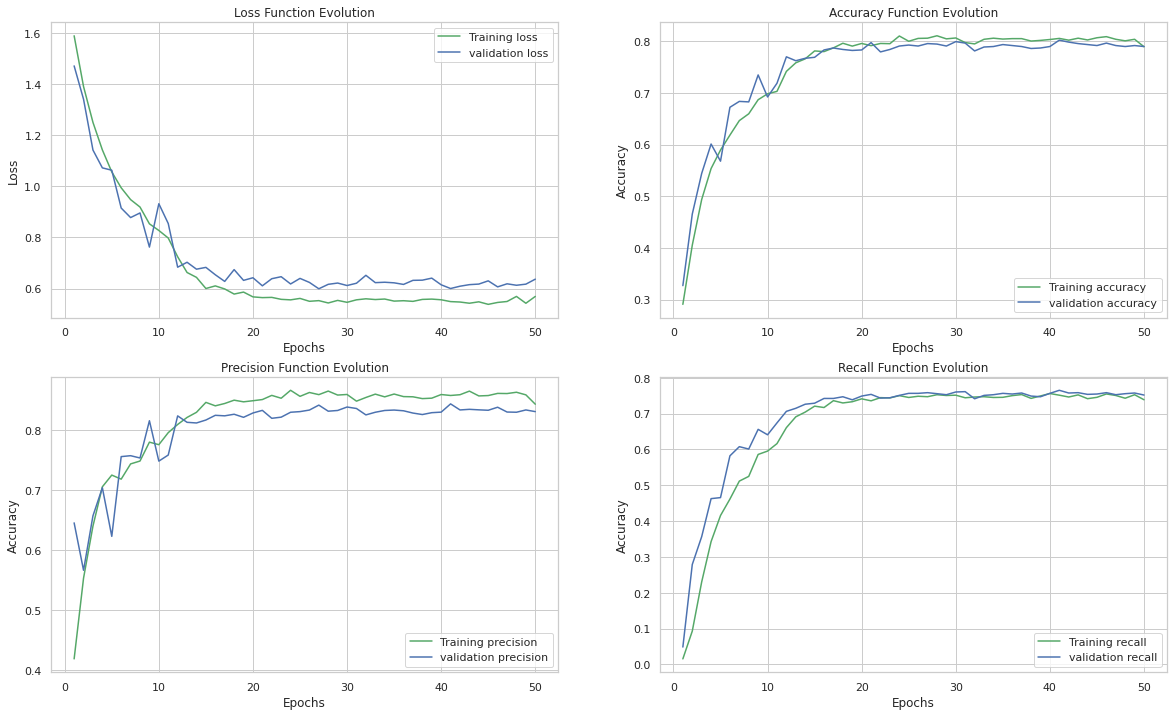

In [ ]:
evolution(model1_history,50)

In [ ]:
cnn_model1.save('cnn_model1.h5')
cnn_model1.save_weights('cnn_model1_weights.h5')

We need to add a few layers and make the model more complex. But for that we can import the weights of pretrained models,

# 4.3. Transfer Learning with MobileNetV2 [model 1]

In [ ]:
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.applications import MobileNetV2

In [ ]:
base_model = MobileNetV2(input_shape=(img_height, img_width, num_channels),
                                               include_top=False,
                                               weights='imagenet')

9420800/9406464 [==============================] - 0s 0us/step


In [ ]:
image_batch, label_batch = next(iter(train_ds))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 7, 7, 1280)

In [ ]:
base_model.trainable = False

In [ ]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 1280)


In [ ]:
prediction_layer = tf.keras.layers.Dense(num_classes, 'softmax')
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 5)


In [ ]:
inputs = tf.keras.Input(shape=(img_height, img_width, num_channels))
x = augment(inputs)
x = rescale(x)
x = base_model(x, training=False)
x = global_average_layer(x)
outputs = prediction_layer(x)
model2_mobileNet = Model(inputs, outputs)

In [ ]:
model2_mobileNet.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics= metrics)

In [ ]:
model2_history = model2_mobileNet.fit(
    train_ds,
    validation_data=val_ds,
    epochs=30,
    callbacks = [learning_rate_reduction],
)

74/74 [==============================] - 23s 260ms/step - loss: 0.8635 - accuracy: 0.6777 - precision: 0.8156 - recall: 0.6061 - val_loss: 0.4955 - val_accuracy: 0.8768 - val_precision: 0.9549 - val_recall: 0.7820

74/74 [==============================] - 19s 246ms/step - loss: 0.4100 - accuracy: 0.8759 - precision: 0.9230 - recall: 0.8155 - val_loss: 0.3347 - val_accuracy: 0.9185 - val_precision: 0.9589 - val_recall: 0.8626

74/74 [==============================] - 18s 236ms/step - loss: 0.3163 - accuracy: 0.9018 - precision: 0.9311 - recall: 0.8618 - val_loss: 0.2976 - val_accuracy: 0.9185 - val_precision: 0.9521 - val_recall: 0.8853

74/74 [==============================] - 19s 244ms/step - loss: 0.2605 - accuracy: 0.9205 - precision: 0.9452 - recall: 0.8946 - val_loss: 0.2517 - val_accuracy: 0.9318 - val_precision: 0.9519 - val_recall: 0.9005

74/74 [==============================] - 18s 230ms/step - loss: 0.2414 - accuracy: 0.9209 - precision: 0.9436 - recall: 0.9035 - val_loss: 0.2267 - val_accuracy: 0.9384 - val_precision: 0.9570 - val_recall: 0.9081

74/74 [==============================] - 18s 230ms/step - loss: 0.2090 - accuracy: 0.9349 - precision: 0.9553 - recall: 0.9167 - val_loss: 0.2266 - val_accuracy: 0.9365 - val_precision: 0.9561 - val_recall: 0.9081

74/74 [==============================] - 19s 239ms/step - loss: 0.2024 - accuracy: 0.9358 - precision: 0.9499 - recall: 0.9196 - val_loss: 0.1851 - val_accuracy: 0.9431 - val_precision: 0.9645 - val_recall: 0.9270

74/74 [==============================] - 18s 234ms/step - loss: 0.1834 - accuracy: 0.9456 - precision: 0.9584 - recall: 0.9307 - val_loss: 0.1701 - val_accuracy: 0.9526 - val_precision: 0.9641 - val_recall: 0.9431

74/74 [==============================] - 19s 236ms/step - loss: 0.1765 - accuracy: 0.9430 - precision: 0.9574 - recall: 0.9273 - val_loss: 0.1725 - val_accuracy: 0.9507 - val_precision: 0.9594 - val_recall: 0.9403

74/74 [==============================] - 19s 245ms/step - loss: 0.1620 - accuracy: 0.9469 - precision: 0.9607 - recall: 0.9362 - val_loss: 0.1600 - val_accuracy: 0.9498 - val_precision: 0.9622 - val_recall: 0.9403

74/74 [==============================] - 18s 232ms/step - loss: 0.1684 - accuracy: 0.9473 - precision: 0.9577 - recall: 0.9345 - val_loss: 0.1616 - val_accuracy: 0.9536 - val_precision: 0.9670 - val_recall: 0.9441

74/74 [==============================] - 19s 242ms/step - loss: 0.1511 - accuracy: 0.9566 - precision: 0.9655 - recall: 0.9405 - val_loss: 0.1546 - val_accuracy: 0.9555 - val_precision: 0.9662 - val_recall: 0.9479

74/74 [==============================] - 19s 249ms/step - loss: 0.1511 - accuracy: 0.9537 - precision: 0.9636 - recall: 0.9443 - val_loss: 0.1631 - val_accuracy: 0.9507 - val_precision: 0.9630 - val_recall: 0.9374

74/74 [==============================] - 19s 238ms/step - loss: 0.1415 - accuracy: 0.9609 - precision: 0.9713 - recall: 0.9486 - val_loss: 0.1510 - val_accuracy: 0.9564 - val_precision: 0.9698 - val_recall: 0.9422

74/74 [==============================] - 20s 250ms/step - loss: 0.1501 - accuracy: 0.9537 - precision: 0.9619 - recall: 0.9456 - val_loss: 0.1520 - val_accuracy: 0.9573 - val_precision: 0.9672 - val_recall: 0.9498

74/74 [==============================] - 19s 236ms/step - loss: 0.1509 - accuracy: 0.9528 - precision: 0.9639 - recall: 0.9426 - val_loss: 0.1491 - val_accuracy: 0.9545 - val_precision: 0.9688 - val_recall: 0.9431

74/74 [==============================] - 19s 234ms/step - loss: 0.1444 - accuracy: 0.9566 - precision: 0.9645 - recall: 0.9469 - val_loss: 0.1493 - val_accuracy: 0.9545 - val_precision: 0.9671 - val_recall: 0.9460

74/74 [==============================] - 19s 245ms/step - loss: 0.1368 - accuracy: 0.9613 - precision: 0.9684 - recall: 0.9511 - val_loss: 0.1496 - val_accuracy: 0.9536 - val_precision: 0.9671 - val_recall: 0.9460

74/74 [==============================] - 19s 238ms/step - loss: 0.1371 - accuracy: 0.9592 - precision: 0.9717 - recall: 0.9498 - val_loss: 0.1447 - val_accuracy: 0.9592 - val_precision: 0.9699 - val_recall: 0.9469

74/74 [==============================] - 19s 248ms/step - loss: 0.1418 - accuracy: 0.9600 - precision: 0.9690 - recall: 0.9430 - val_loss: 0.1470 - val_accuracy: 0.9545 - val_precision: 0.9681 - val_recall: 0.9479

74/74 [==============================] - 20s 250ms/step - loss: 0.1456 - accuracy: 0.9537 - precision: 0.9644 - recall: 0.9452 - val_loss: 0.1384 - val_accuracy: 0.9583 - val_precision: 0.9708 - val_recall: 0.9460

74/74 [==============================] - 19s 237ms/step - loss: 0.1377 - accuracy: 0.9541 - precision: 0.9631 - recall: 0.9443 - val_loss: 0.1505 - val_accuracy: 0.9555 - val_precision: 0.9661 - val_recall: 0.9450

74/74 [==============================] - 19s 247ms/step - loss: 0.1528 - accuracy: 0.9498 - precision: 0.9580 - recall: 0.9418 - val_loss: 0.1501 - val_accuracy: 0.9555 - val_precision: 0.9661 - val_recall: 0.9450

74/74 [==============================] - 19s 237ms/step - loss: 0.1298 - accuracy: 0.9575 - precision: 0.9663 - recall: 0.9503 - val_loss: 0.1446 - val_accuracy: 0.9564 - val_precision: 0.9689 - val_recall: 0.9460

74/74 [==============================] - 19s 238ms/step - loss: 0.1424 - accuracy: 0.9558 - precision: 0.9666 - recall: 0.9464 - val_loss: 0.1443 - val_accuracy: 0.9592 - val_precision: 0.9691 - val_recall: 0.9507

74/74 [==============================] - 19s 238ms/step - loss: 0.1394 - accuracy: 0.9571 - precision: 0.9641 - recall: 0.9490 - val_loss: 0.1419 - val_accuracy: 0.9602 - val_precision: 0.9690 - val_recall: 0.9488

74/74 [==============================] - 19s 235ms/step - loss: 0.1375 - accuracy: 0.9583 - precision: 0.9622 - recall: 0.9511 - val_loss: 0.1488 - val_accuracy: 0.9573 - val_precision: 0.9652 - val_recall: 0.9460

74/74 [==============================] - 19s 245ms/step - loss: 0.1280 - accuracy: 0.9613 - precision: 0.9719 - recall: 0.9545 - val_loss: 0.1507 - val_accuracy: 0.9564 - val_precision: 0.9652 - val_recall: 0.9450

74/74 [==============================] - 19s 244ms/step - loss: 0.1333 - accuracy: 0.9575 - precision: 0.9675 - recall: 0.9503 - val_loss: 0.1449 - val_accuracy: 0.9573 - val_precision: 0.9662 - val_recall: 0.9469

74/74 [==============================] - 18s 231ms/step - loss: 0.1301 - accuracy: 0.9609 - precision: 0.9676 - recall: 0.9524 - val_loss: 0.1578 - val_accuracy: 0.9498 - val_precision: 0.9603 - val_recall: 0.9393

()

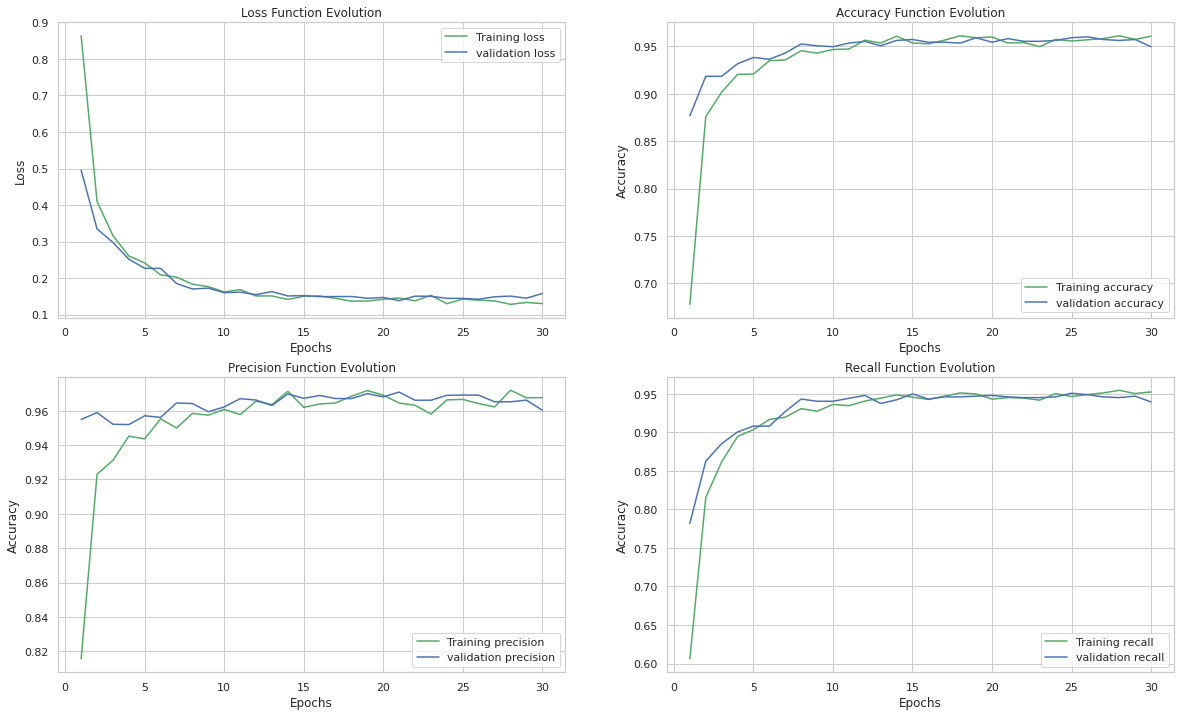

In [ ]:
evolution(model2_history,30)

In [ ]:
model2_mobileNet.save('model2_mobileNet.h5')
model2_mobileNet.save_weights('model2_mobileNet_weights.h5')

/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


# 4.4. Transfer Learning with VGG16 [Model2]

In [ ]:
from tensorflow.keras.applications import VGG16

base_modelvgg16 = VGG16(input_shape=(img_height, img_width, num_channels),
                                               include_top=False,
                                               weights='imagenet')

image_batch, labels_batch = next(iter(train_ds))
feature_batch = base_modelvgg16(image_batch)
print('Feature Batch shape:', feature_batch.shape)

base_modelvgg16.trainable = False

global_average_layer = GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print('Feature Batch average shape:', feature_batch_average.shape)

prediction_layer = Dense(num_classes, 'softmax')
prediction_batch = prediction_layer(feature_batch_average)
print('Prediction Batch shape:', prediction_batch.shape)

inputs = Input(shape=(img_height, img_width, num_channels))
x = augment(inputs)
x = rescale(x)
x = base_modelvgg16(x, training=False)
x = global_average_layer(x)
x = Dropout(0.3)(x)

outputs = prediction_layer(x)

model3_VGG16 = Model(inputs, outputs)

model3_VGG16.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics= metrics)

model3_history = model3_VGG16.fit(
    train_ds,
    validation_data=val_ds,
    epochs=41,
    callbacks = [learning_rate_reduction],
)

evolution(model3_history,41)

58889256 [==============================] - 0s 0us/step
58900480/58889256 [==============================] - 0s 0us/step
eanup cal
74/74 [==============================] - 29s 320ms/step - loss: 1.5904 - accuracy: 0.3099 - precision: 0.8906 - recall: 0.3035 - val_loss: 1.4324 - val_accuracy: 0.4626 - val_precision: 1.0000 - val_recall: 9.4787e-04

74/74 [==============================] - 20s 255ms/step - loss: 1.3233 - accuracy: 0.5043 - precision: 0.9403 - recall: 0.0536 - val_loss: 1.2501 - val_accuracy: 0.6512 - val_precision: 0.9783 - val_recall: 0.0427

74/74 [==============================] - 19s 246ms/step - loss: 1.1798 - accuracy: 0.5927 - precision: 0.9551 - recall: 0.1539 - val_loss: 1.1372 - val_accuracy: 0.7441 - val_precision: 0.9796 - val_recall: 0.0910

74/74 [==============================] - 20s 257ms/step - loss: 1.0767 - accuracy: 0.6318 - precision: 0.9276 - recall: 0.2287 - val_loss: 1.0386 - val_accuracy: 0.7602 - val_precision: 0.9677 - val_recall: 0.1706

74/74 [==============================] - 20s 254ms/step - loss: 1.0055 - accuracy: 0.6662 - precision: 0.9255 - recall: 0.3065 - val_loss: 0.9617 - val_accuracy: 0.7848 - val_precision: 0.9556 - val_recall: 0.2246

74/74 [==============================] - 19s 243ms/step - loss: 0.9549 - accuracy: 0.6879 - precision: 0.9123 - recall: 0.3537 - val_loss: 0.9000 - val_accuracy: 0.7962 - val_precision: 0.9665 - val_recall: 0.3005

74/74 [==============================] - 20s 251ms/step - loss: 0.8991 - accuracy: 0.7173 - precision: 0.9222 - recall: 0.4031 - val_loss: 0.8484 - val_accuracy: 0.8218 - val_precision: 0.9714 - val_recall: 0.3858

74/74 [==============================] - 20s 256ms/step - loss: 0.8794 - accuracy: 0.7100 - precision: 0.8996 - recall: 0.4264 - val_loss: 0.8120 - val_accuracy: 0.8265 - val_precision: 0.9641 - val_recall: 0.4578

74/74 [==============================] - 19s 248ms/step - loss: 0.8421 - accuracy: 0.7364 - precision: 0.9002 - recall: 0.4677 - val_loss: 0.7783 - val_accuracy: 0.8218 - val_precision: 0.9670 - val_recall: 0.4995

74/74 [==============================] - 20s 254ms/step - loss: 0.8139 - accuracy: 0.7394 - precision: 0.9054 - recall: 0.4962 - val_loss: 0.7477 - val_accuracy: 0.8246 - val_precision: 0.9597 - val_recall: 0.5422

74/74 [==============================] - 19s 242ms/step - loss: 0.7959 - accuracy: 0.7423 - precision: 0.8954 - recall: 0.5094 - val_loss: 0.7283 - val_accuracy: 0.8332 - val_precision: 0.9606 - val_recall: 0.5545

74/74 [==============================] - 20s 253ms/step - loss: 0.7822 - accuracy: 0.7594 - precision: 0.8970 - recall: 0.5183 - val_loss: 0.7247 - val_accuracy: 0.8303 - val_precision: 0.9593 - val_recall: 0.5583

74/74 [==============================] - 20s 253ms/step - loss: 0.7827 - accuracy: 0.7534 - precision: 0.9104 - recall: 0.5268 - val_loss: 0.7036 - val_accuracy: 0.8445 - val_precision: 0.9575 - val_recall: 0.5763

74/74 [==============================] - 19s 245ms/step - loss: 0.7622 - accuracy: 0.7598 - precision: 0.9113 - recall: 0.5332 - val_loss: 0.7005 - val_accuracy: 0.8408 - val_precision: 0.9605 - val_recall: 0.5763

74/74 [==============================] - 20s 261ms/step - loss: 0.7679 - accuracy: 0.7470 - precision: 0.8962 - recall: 0.5434 - val_loss: 0.6927 - val_accuracy: 0.8512 - val_precision: 0.9581 - val_recall: 0.5848

74/74 [==============================] - 20s 255ms/step - loss: 0.7663 - accuracy: 0.7491 - precision: 0.8911 - recall: 0.5391 - val_loss: 0.6902 - val_accuracy: 0.8445 - val_precision: 0.9554 - val_recall: 0.5886

74/74 [==============================] - 19s 247ms/step - loss: 0.7524 - accuracy: 0.7577 - precision: 0.8916 - recall: 0.5493 - val_loss: 0.6805 - val_accuracy: 0.8417 - val_precision: 0.9563 - val_recall: 0.6009

74/74 [==============================] - 19s 250ms/step - loss: 0.7425 - accuracy: 0.7623 - precision: 0.9021 - recall: 0.5523 - val_loss: 0.6776 - val_accuracy: 0.8483 - val_precision: 0.9522 - val_recall: 0.6038

74/74 [==============================] - 19s 243ms/step - loss: 0.7553 - accuracy: 0.7538 - precision: 0.8889 - recall: 0.5510 - val_loss: 0.6808 - val_accuracy: 0.8455 - val_precision: 0.9545 - val_recall: 0.5962

74/74 [==============================] - 19s 242ms/step - loss: 0.7581 - accuracy: 0.7504 - precision: 0.8975 - recall: 0.5544 - val_loss: 0.6756 - val_accuracy: 0.8483 - val_precision: 0.9558 - val_recall: 0.6152

74/74 [==============================] - 20s 254ms/step - loss: 0.7317 - accuracy: 0.7708 - precision: 0.9054 - recall: 0.5697 - val_loss: 0.6800 - val_accuracy: 0.8464 - val_precision: 0.9525 - val_recall: 0.6076

74/74 [==============================] - 19s 246ms/step - loss: 0.7417 - accuracy: 0.7730 - precision: 0.8950 - recall: 0.5582 - val_loss: 0.6655 - val_accuracy: 0.8512 - val_precision: 0.9598 - val_recall: 0.6114

74/74 [==============================] - 20s 255ms/step - loss: 0.7485 - accuracy: 0.7589 - precision: 0.9015 - recall: 0.5485 - val_loss: 0.6734 - val_accuracy: 0.8474 - val_precision: 0.9567 - val_recall: 0.6066

74/74 [==============================] - 19s 250ms/step - loss: 0.7342 - accuracy: 0.7623 - precision: 0.9101 - recall: 0.5680 - val_loss: 0.6654 - val_accuracy: 0.8502 - val_precision: 0.9573 - val_recall: 0.6161

74/74 [==============================] - 19s 241ms/step - loss: 0.7427 - accuracy: 0.7683 - precision: 0.8967 - recall: 0.5612 - val_loss: 0.6692 - val_accuracy: 0.8512 - val_precision: 0.9578 - val_recall: 0.6028

74/74 [==============================] - 20s 250ms/step - loss: 0.7381 - accuracy: 0.7725 - precision: 0.9024 - recall: 0.5663 - val_loss: 0.6695 - val_accuracy: 0.8436 - val_precision: 0.9593 - val_recall: 0.6028

74/74 [==============================] - 20s 256ms/step - loss: 0.7396 - accuracy: 0.7649 - precision: 0.8883 - recall: 0.5680 - val_loss: 0.6786 - val_accuracy: 0.8408 - val_precision: 0.9535 - val_recall: 0.6019

74/74 [==============================] - 19s 246ms/step - loss: 0.7446 - accuracy: 0.7585 - precision: 0.8951 - recall: 0.5625 - val_loss: 0.6612 - val_accuracy: 0.8521 - val_precision: 0.9573 - val_recall: 0.6161

74/74 [==============================] - 20s 255ms/step - loss: 0.7391 - accuracy: 0.7628 - precision: 0.8975 - recall: 0.5621 - val_loss: 0.6687 - val_accuracy: 0.8445 - val_precision: 0.9592 - val_recall: 0.6019

74/74 [==============================] - 20s 254ms/step - loss: 0.7465 - accuracy: 0.7662 - precision: 0.9012 - recall: 0.5582 - val_loss: 0.6695 - val_accuracy: 0.8474 - val_precision: 0.9580 - val_recall: 0.6047

74/74 [==============================] - 19s 241ms/step - loss: 0.7409 - accuracy: 0.7657 - precision: 0.8938 - recall: 0.5544 - val_loss: 0.6826 - val_accuracy: 0.8379 - val_precision: 0.9517 - val_recall: 0.5972

74/74 [==============================] - 20s 254ms/step - loss: 0.7371 - accuracy: 0.7738 - precision: 0.9072 - recall: 0.5651 - val_loss: 0.6716 - val_accuracy: 0.8474 - val_precision: 0.9553 - val_recall: 0.6076

74/74 [==============================] - 19s 248ms/step - loss: 0.7507 - accuracy: 0.7594 - precision: 0.8942 - recall: 0.5604 - val_loss: 0.6731 - val_accuracy: 0.8493 - val_precision: 0.9550 - val_recall: 0.6038

74/74 [==============================] - 20s 252ms/step - loss: 0.7495 - accuracy: 0.7534 - precision: 0.8884 - recall: 0.5417 - val_loss: 0.6772 - val_accuracy: 0.8408 - val_precision: 0.9593 - val_recall: 0.6028

74/74 [==============================] - 20s 253ms/step - loss: 0.7622 - accuracy: 0.7440 - precision: 0.9047 - recall: 0.5489 - val_loss: 0.6667 - val_accuracy: 0.8502 - val_precision: 0.9596 - val_recall: 0.6076

74/74 [==============================] - 19s 244ms/step - loss: 0.7616 - accuracy: 0.7526 - precision: 0.8932 - recall: 0.5510 - val_loss: 0.6682 - val_accuracy: 0.8493 - val_precision: 0.9572 - val_recall: 0.6152

74/74 [==============================] - 21s 263ms/step - loss: 0.7442 - accuracy: 0.7653 - precision: 0.9039 - recall: 0.5599 - val_loss: 0.6781 - val_accuracy: 0.8408 - val_precision: 0.9522 - val_recall: 0.6047

74/74 [==============================] - 20s 254ms/step - loss: 0.7498 - accuracy: 0.7581 - precision: 0.9054 - recall: 0.5697 - val_loss: 0.6794 - val_accuracy: 0.8427 - val_precision: 0.9533 - val_recall: 0.6000

74/74 [==============================] - 19s 246ms/step - loss: 0.7413 - accuracy: 0.7628 - precision: 0.8939 - recall: 0.5591 - val_loss: 0.6666 - val_accuracy: 0.8493 - val_precision: 0.9585 - val_recall: 0.6133

74/74 [==============================] - 20s 253ms/step - loss: 0.7493 - accuracy: 0.7521 - precision: 0.8906 - recall: 0.5468 - val_loss: 0.6695 - val_accuracy: 0.8502 - val_precision: 0.9562 - val_recall: 0.6000

74/74 [==============================] - 19s 243ms/step - loss: 0.7492 - accuracy: 0.7491 - precision: 0.9088 - recall: 0.5553 - val_loss: 0.6636 - val_accuracy: 0.8588 - val_precision: 0.9585 - val_recall: 0.6133
()

()

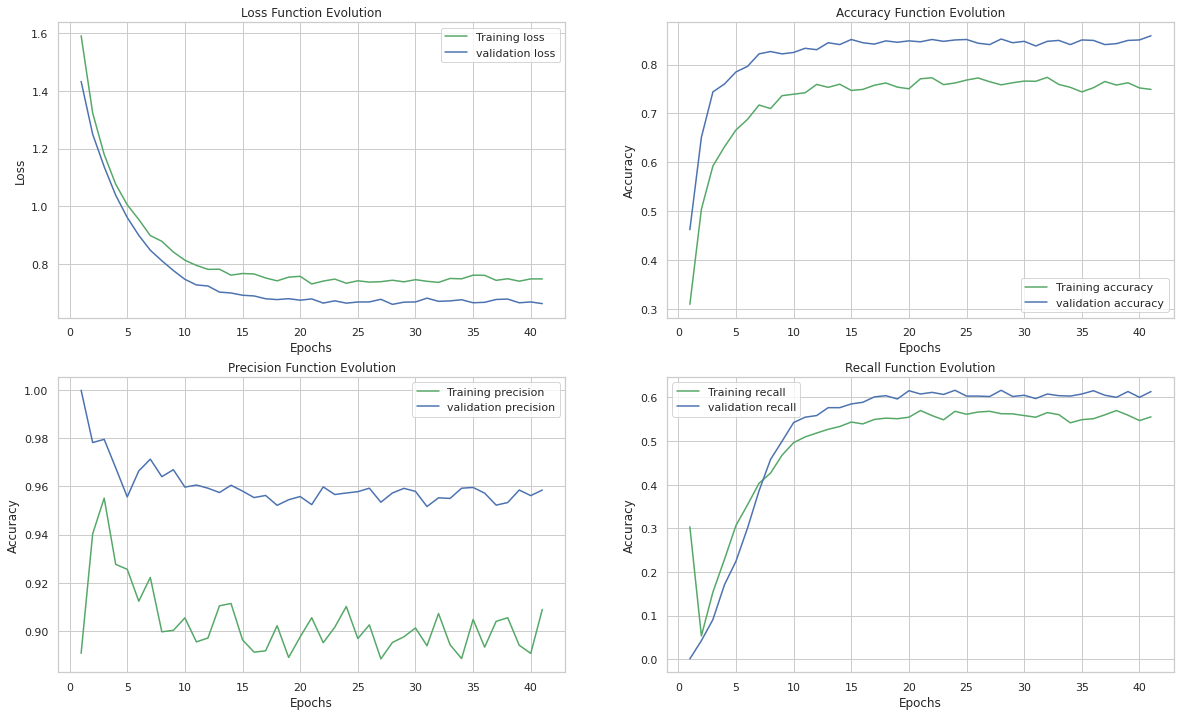

In [ ]:
evolution(model3_history,41)

In [ ]:
model3_VGG16.save('model3_VGG16.h5')
model3_VGG16.save_weights('model3_VGG16_weights.h5')

# 4.5. Transfer Learning with Resnet50 [Model3]

In [ ]:
from tensorflow.keras.applications import ResNet50V2

base_modelresnet50 = ResNet50V2(input_shape = (img_height,img_width,num_channels),
                   weights='imagenet',
                   include_top=False)

image_batch, labels_batch = next(iter(train_ds))
feature_batch = base_modelresnet50(image_batch)
print('Feature Batch shape:', feature_batch.shape)

base_modelresnet50.trainable = False

global_average_layer = GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print('Feature Batch average shape:', feature_batch_average.shape)

prediction_layer = Dense(num_classes, 'softmax')
prediction_batch = prediction_layer(feature_batch_average)
print('Prediction Batch shape:', prediction_batch.shape)

inputs = Input(shape=(img_height, img_width, num_channels))
x = augment(inputs)
x = rescale(x)
x = base_modelresnet50(x, training=False)
x = global_average_layer(x)
x = Dropout(0.3)(x)

outputs = prediction_layer(x)

model4_resnet = Model(inputs, outputs)

model4_resnet.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics= metrics)

model4_history = model4_resnet.fit(
    train_ds,
    validation_data=val_ds,
    epochs=20,
    callbacks = [learning_rate_reduction],
)



Downloading data from https://storage.googleapis.com/tensorflow/keras-applications/resnet/resnet50v2_weights_tf_dim_ordering_tf_kernels_notop.h5
94674944/94668760 [==============================] - 1s 0us/step
94683136/94668760 [==============================] - 1s 0us/step
74/74 [==============================] - 25s 272ms/step - loss: 0.8354 - accuracy: 0.6764 - precision: 0.8292 - recall: 0.6041 - val_loss: 0.2892 - val_accuracy: 0.9289 - val_precision: 0.9514 - val_recall: 0.8910

74/74 [==============================] - 19s 244ms/step - loss: 0.3550 - accuracy: 0.8767 - precision: 0.9098 - recall: 0.8452 - val_loss: 0.2144 - val_accuracy: 0.9393 - val_precision: 0.9576 - val_recall: 0.9213

74/74 [==============================] - 20s 259ms/step - loss: 0.2899 - accuracy: 0.9056 - precision: 0.9312 - recall: 0.8869 - val_loss: 0.1935 - val_accuracy: 0.9431 - val_precision: 0.9541 - val_recall: 0.9261

74/74 [==============================] - 22s 289ms/step - loss: 0.2611 - accuracy: 0.9094 - precision: 0.9295 - recall: 0.8916 - val_loss: 0.1439 - val_accuracy: 0.9630 - val_precision: 0.9701 - val_recall: 0.9526

74/74 [==============================] - 21s 254ms/step - loss: 0.2224 - accuracy: 0.9247 - precision: 0.9411 - recall: 0.9099 - val_loss: 0.1350 - val_accuracy: 0.9555 - val_precision: 0.9737 - val_recall: 0.9479

74/74 [==============================] - 20s 253ms/step - loss: 0.2223 - accuracy: 0.9290 - precision: 0.9422 - recall: 0.9145 - val_loss: 0.1393 - val_accuracy: 0.9583 - val_precision: 0.9672 - val_recall: 0.9507

74/74 [==============================] - 19s 241ms/step - loss: 0.1967 - accuracy: 0.9311 - precision: 0.9441 - recall: 0.9188 - val_loss: 0.1266 - val_accuracy: 0.9668 - val_precision: 0.9721 - val_recall: 0.9583

74/74 [==============================] - 20s 251ms/step - loss: 0.1935 - accuracy: 0.9307 - precision: 0.9422 - recall: 0.9150 - val_loss: 0.1313 - val_accuracy: 0.9630 - val_precision: 0.9702 - val_recall: 0.9555

74/74 [==============================] - 20s 253ms/step - loss: 0.1992 - accuracy: 0.9345 - precision: 0.9461 - recall: 0.9188 - val_loss: 0.1221 - val_accuracy: 0.9678 - val_precision: 0.9702 - val_recall: 0.9564

74/74 [==============================] - 19s 246ms/step - loss: 0.1775 - accuracy: 0.9362 - precision: 0.9524 - recall: 0.9264 - val_loss: 0.1241 - val_accuracy: 0.9678 - val_precision: 0.9703 - val_recall: 0.9602

74/74 [==============================] - 20s 255ms/step - loss: 0.1841 - accuracy: 0.9337 - precision: 0.9506 - recall: 0.9239 - val_loss: 0.1163 - val_accuracy: 0.9678 - val_precision: 0.9712 - val_recall: 0.9602

74/74 [==============================] - 19s 241ms/step - loss: 0.1721 - accuracy: 0.9392 - precision: 0.9540 - recall: 0.9269 - val_loss: 0.1143 - val_accuracy: 0.9687 - val_precision: 0.9731 - val_recall: 0.9592

74/74 [==============================] - 20s 249ms/step - loss: 0.1906 - accuracy: 0.9337 - precision: 0.9411 - recall: 0.9243 - val_loss: 0.1145 - val_accuracy: 0.9668 - val_precision: 0.9731 - val_recall: 0.9602

74/74 [==============================] - 20s 260ms/step - loss: 0.1803 - accuracy: 0.9430 - precision: 0.9527 - recall: 0.9332 - val_loss: 0.1105 - val_accuracy: 0.9678 - val_precision: 0.9741 - val_recall: 0.9621

74/74 [==============================] - 19s 245ms/step - loss: 0.1761 - accuracy: 0.9401 - precision: 0.9493 - recall: 0.9307 - val_loss: 0.1095 - val_accuracy: 0.9716 - val_precision: 0.9769 - val_recall: 0.9630

74/74 [==============================] - 20s 255ms/step - loss: 0.1767 - accuracy: 0.9413 - precision: 0.9518 - recall: 0.9324 - val_loss: 0.1155 - val_accuracy: 0.9687 - val_precision: 0.9740 - val_recall: 0.9583

74/74 [==============================] - 20s 256ms/step - loss: 0.1691 - accuracy: 0.9443 - precision: 0.9536 - recall: 0.9349 - val_loss: 0.1135 - val_accuracy: 0.9687 - val_precision: 0.9769 - val_recall: 0.9611

74/74 [==============================] - 19s 244ms/step - loss: 0.1662 - accuracy: 0.9426 - precision: 0.9530 - recall: 0.9320 - val_loss: 0.1115 - val_accuracy: 0.9668 - val_precision: 0.9740 - val_recall: 0.9592

74/74 [==============================] - 20s 250ms/step - loss: 0.1777 - accuracy: 0.9409 - precision: 0.9512 - recall: 0.9281 - val_loss: 0.1104 - val_accuracy: 0.9668 - val_precision: 0.9740 - val_recall: 0.9573

74/74 [==============================] - 19s 248ms/step - loss: 0.1731 - accuracy: 0.9460 - precision: 0.9540 - recall: 0.9354 - val_loss: 0.1059 - val_accuracy: 0.9716 - val_precision: 0.9788 - val_recall: 0.9630

()

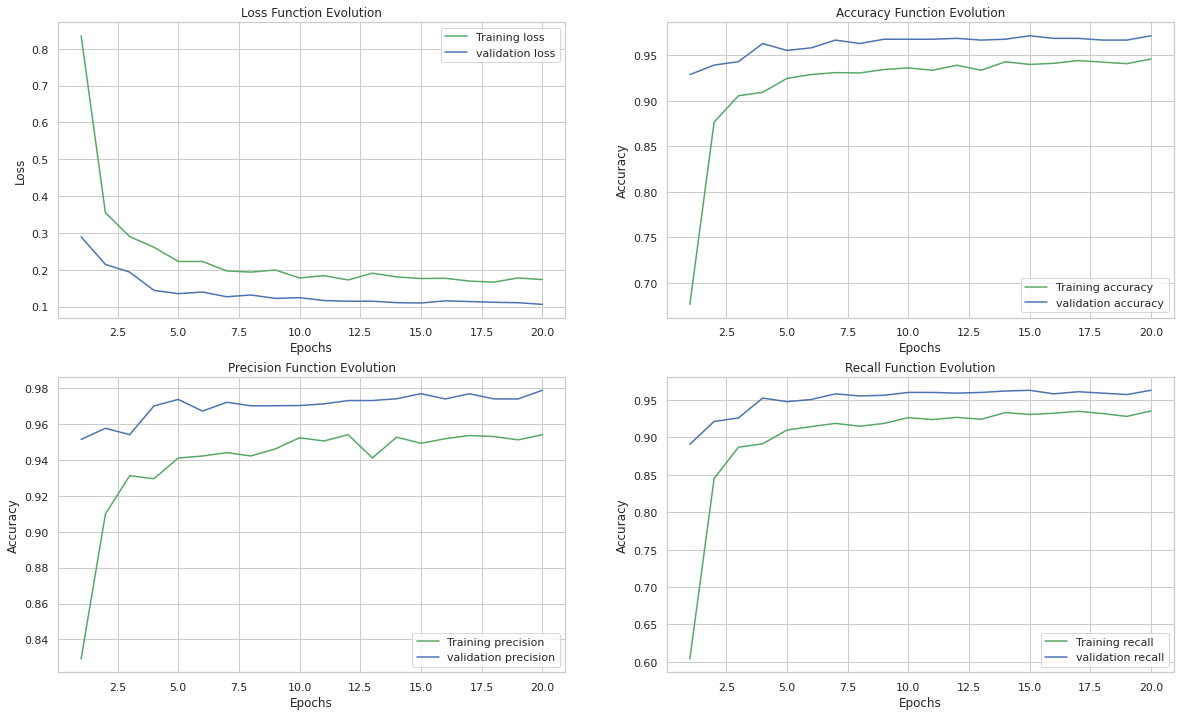

In [ ]:
evolution(model4_history,20)

model4_resnet is already trained for 20 epochs. We will train it for 50 more epochs, making total epochs to be 70.

In [ ]:
model4_history = model4_resnet.fit(
    train_ds,
    validation_data=val_ds,
    epochs=50,
    callbacks = [learning_rate_reduction],
)

74/74 [==============================] - 20s 252ms/step - loss: 0.1798 - accuracy: 0.9396 - precision: 0.9484 - recall: 0.9303 - val_loss: 0.1128 - val_accuracy: 0.9678 - val_precision: 0.9759 - val_recall: 0.9602

74/74 [==============================] - 20s 253ms/step - loss: 0.1603 - accuracy: 0.9473 - precision: 0.9566 - recall: 0.9362 - val_loss: 0.1094 - val_accuracy: 0.9697 - val_precision: 0.9769 - val_recall: 0.9621

74/74 [==============================] - 19s 247ms/step - loss: 0.1748 - accuracy: 0.9409 - precision: 0.9529 - recall: 0.9298 - val_loss: 0.1138 - val_accuracy: 0.9678 - val_precision: 0.9749 - val_recall: 0.9583

74/74 [==============================] - 20s 261ms/step - loss: 0.1712 - accuracy: 0.9430 - precision: 0.9546 - recall: 0.9303 - val_loss: 0.1179 - val_accuracy: 0.9659 - val_precision: 0.9740 - val_recall: 0.9573

74/74 [==============================] - 20s 257ms/step - loss: 0.1723 - accuracy: 0.9401 - precision: 0.9521 - recall: 0.9294 - val_loss: 0.1137 - val_accuracy: 0.9668 - val_precision: 0.9740 - val_recall: 0.9573

74/74 [==============================] - 19s 248ms/step - loss: 0.1633 - accuracy: 0.9447 - precision: 0.9561 - recall: 0.9354 - val_loss: 0.1081 - val_accuracy: 0.9678 - val_precision: 0.9750 - val_recall: 0.9602

74/74 [==============================] - 20s 258ms/step - loss: 0.1877 - accuracy: 0.9405 - precision: 0.9473 - recall: 0.9256 - val_loss: 0.1080 - val_accuracy: 0.9687 - val_precision: 0.9769 - val_recall: 0.9602

74/74 [==============================] - 19s 247ms/step - loss: 0.1662 - accuracy: 0.9460 - precision: 0.9525 - recall: 0.9371 - val_loss: 0.1141 - val_accuracy: 0.9668 - val_precision: 0.9749 - val_recall: 0.9573

74/74 [==============================] - 20s 244ms/step - loss: 0.1767 - accuracy: 0.9447 - precision: 0.9545 - recall: 0.9358 - val_loss: 0.1074 - val_accuracy: 0.9706 - val_precision: 0.9788 - val_recall: 0.9630

74/74 [==============================] - 20s 257ms/step - loss: 0.1714 - accuracy: 0.9469 - precision: 0.9554 - recall: 0.9384 - val_loss: 0.1157 - val_accuracy: 0.9687 - val_precision: 0.9750 - val_recall: 0.9602

74/74 [==============================] - 19s 248ms/step - loss: 0.1815 - accuracy: 0.9430 - precision: 0.9537 - recall: 0.9286 - val_loss: 0.1049 - val_accuracy: 0.9706 - val_precision: 0.9797 - val_recall: 0.9621

74/74 [==============================] - 20s 253ms/step - loss: 0.1853 - accuracy: 0.9392 - precision: 0.9478 - recall: 0.9256 - val_loss: 0.1093 - val_accuracy: 0.9678 - val_precision: 0.9750 - val_recall: 0.9592

74/74 [==============================] - 20s 255ms/step - loss: 0.1703 - accuracy: 0.9405 - precision: 0.9498 - recall: 0.9341 - val_loss: 0.1158 - val_accuracy: 0.9687 - val_precision: 0.9758 - val_recall: 0.9573

74/74 [==============================] - 19s 249ms/step - loss: 0.1676 - accuracy: 0.9443 - precision: 0.9544 - recall: 0.9345 - val_loss: 0.1074 - val_accuracy: 0.9687 - val_precision: 0.9759 - val_recall: 0.9611

74/74 [==============================] - 20s 255ms/step - loss: 0.1689 - accuracy: 0.9490 - precision: 0.9582 - recall: 0.9358 - val_loss: 0.1093 - val_accuracy: 0.9678 - val_precision: 0.9759 - val_recall: 0.9602

74/74 [==============================] - 20s 262ms/step - loss: 0.1722 - accuracy: 0.9473 - precision: 0.9544 - recall: 0.9345 - val_loss: 0.1150 - val_accuracy: 0.9659 - val_precision: 0.9730 - val_recall: 0.9564

74/74 [==============================] - 20s 250ms/step - loss: 0.1631 - accuracy: 0.9456 - precision: 0.9575 - recall: 0.9384 - val_loss: 0.1103 - val_accuracy: 0.9697 - val_precision: 0.9759 - val_recall: 0.9602

74/74 [==============================] - 20s 254ms/step - loss: 0.1725 - accuracy: 0.9443 - precision: 0.9556 - recall: 0.9332 - val_loss: 0.1061 - val_accuracy: 0.9706 - val_precision: 0.9779 - val_recall: 0.9630

74/74 [==============================] - 19s 244ms/step - loss: 0.1684 - accuracy: 0.9460 - precision: 0.9552 - recall: 0.9341 - val_loss: 0.1157 - val_accuracy: 0.9668 - val_precision: 0.9759 - val_recall: 0.9583

74/74 [==============================] - 20s 255ms/step - loss: 0.1786 - accuracy: 0.9392 - precision: 0.9481 - recall: 0.9235 - val_loss: 0.1093 - val_accuracy: 0.9687 - val_precision: 0.9759 - val_recall: 0.9611

74/74 [==============================] - 20s 258ms/step - loss: 0.1635 - accuracy: 0.9452 - precision: 0.9565 - recall: 0.9341 - val_loss: 0.1079 - val_accuracy: 0.9697 - val_precision: 0.9769 - val_recall: 0.9602

74/74 [==============================] - 20s 252ms/step - loss: 0.1871 - accuracy: 0.9358 - precision: 0.9483 - recall: 0.9281 - val_loss: 0.1069 - val_accuracy: 0.9697 - val_precision: 0.9769 - val_recall: 0.9621

74/74 [==============================] - 20s 256ms/step - loss: 0.1652 - accuracy: 0.9439 - precision: 0.9546 - recall: 0.9303 - val_loss: 0.1143 - val_accuracy: 0.9668 - val_precision: 0.9740 - val_recall: 0.9573

74/74 [==============================] - 20s 258ms/step - loss: 0.1801 - accuracy: 0.9401 - precision: 0.9508 - recall: 0.9286 - val_loss: 0.1146 - val_accuracy: 0.9659 - val_precision: 0.9730 - val_recall: 0.9564

74/74 [==============================] - 19s 245ms/step - loss: 0.1791 - accuracy: 0.9375 - precision: 0.9486 - recall: 0.9264 - val_loss: 0.1168 - val_accuracy: 0.9649 - val_precision: 0.9730 - val_recall: 0.9573

74/74 [==============================] - 20s 250ms/step - loss: 0.1738 - accuracy: 0.9405 - precision: 0.9490 - recall: 0.9341 - val_loss: 0.1145 - val_accuracy: 0.9697 - val_precision: 0.9759 - val_recall: 0.9611

74/74 [==============================] - 20s 256ms/step - loss: 0.1686 - accuracy: 0.9490 - precision: 0.9548 - recall: 0.9349 - val_loss: 0.1153 - val_accuracy: 0.9668 - val_precision: 0.9749 - val_recall: 0.9583

74/74 [==============================] - 19s 250ms/step - loss: 0.1698 - accuracy: 0.9384 - precision: 0.9503 - recall: 0.9264 - val_loss: 0.1105 - val_accuracy: 0.9697 - val_precision: 0.9759 - val_recall: 0.9611

74/74 [==============================] - 20s 259ms/step - loss: 0.1784 - accuracy: 0.9362 - precision: 0.9474 - recall: 0.9260 - val_loss: 0.1110 - val_accuracy: 0.9668 - val_precision: 0.9740 - val_recall: 0.9592

74/74 [==============================] - 20s 251ms/step - loss: 0.1653 - accuracy: 0.9439 - precision: 0.9578 - recall: 0.9358 - val_loss: 0.1050 - val_accuracy: 0.9706 - val_precision: 0.9779 - val_recall: 0.9630

74/74 [==============================] - 19s 243ms/step - loss: 0.1696 - accuracy: 0.9447 - precision: 0.9562 - recall: 0.9371 - val_loss: 0.1111 - val_accuracy: 0.9668 - val_precision: 0.9759 - val_recall: 0.9583

74/74 [==============================] - 20s 251ms/step - loss: 0.1756 - accuracy: 0.9418 - precision: 0.9529 - recall: 0.9290 - val_loss: 0.1183 - val_accuracy: 0.9659 - val_precision: 0.9740 - val_recall: 0.9573

74/74 [==============================] - 19s 249ms/step - loss: 0.1834 - accuracy: 0.9392 - precision: 0.9486 - recall: 0.9252 - val_loss: 0.1094 - val_accuracy: 0.9668 - val_precision: 0.9759 - val_recall: 0.9583

74/74 [==============================] - 20s 258ms/step - loss: 0.1742 - accuracy: 0.9388 - precision: 0.9497 - recall: 0.9311 - val_loss: 0.1177 - val_accuracy: 0.9640 - val_precision: 0.9720 - val_recall: 0.9555

74/74 [==============================] - 20s 254ms/step - loss: 0.1763 - accuracy: 0.9396 - precision: 0.9517 - recall: 0.9298 - val_loss: 0.1078 - val_accuracy: 0.9697 - val_precision: 0.9769 - val_recall: 0.9611

74/74 [==============================] - 19s 246ms/step - loss: 0.1789 - accuracy: 0.9426 - precision: 0.9531 - recall: 0.9324 - val_loss: 0.1168 - val_accuracy: 0.9659 - val_precision: 0.9740 - val_recall: 0.9583

74/74 [==============================] - 20s 254ms/step - loss: 0.1666 - accuracy: 0.9413 - precision: 0.9540 - recall: 0.9337 - val_loss: 0.1073 - val_accuracy: 0.9706 - val_precision: 0.9778 - val_recall: 0.9611

74/74 [==============================] - 20s 251ms/step - loss: 0.1657 - accuracy: 0.9456 - precision: 0.9549 - recall: 0.9371 - val_loss: 0.1142 - val_accuracy: 0.9678 - val_precision: 0.9749 - val_recall: 0.9583

74/74 [==============================] - 19s 245ms/step - loss: 0.1633 - accuracy: 0.9486 - precision: 0.9575 - recall: 0.9392 - val_loss: 0.1117 - val_accuracy: 0.9697 - val_precision: 0.9769 - val_recall: 0.9602

74/74 [==============================] - 20s 259ms/step - loss: 0.1668 - accuracy: 0.9443 - precision: 0.9551 - recall: 0.9311 - val_loss: 0.1193 - val_accuracy: 0.9649 - val_precision: 0.9739 - val_recall: 0.9555

74/74 [==============================] - 19s 249ms/step - loss: 0.1680 - accuracy: 0.9409 - precision: 0.9530 - recall: 0.9320 - val_loss: 0.1047 - val_accuracy: 0.9716 - val_precision: 0.9788 - val_recall: 0.9621

74/74 [==============================] - 20s 245ms/step - loss: 0.1753 - accuracy: 0.9388 - precision: 0.9488 - recall: 0.9298 - val_loss: 0.1084 - val_accuracy: 0.9697 - val_precision: 0.9769 - val_recall: 0.9611

74/74 [==============================] - 20s 253ms/step - loss: 0.1829 - accuracy: 0.9418 - precision: 0.9558 - recall: 0.9290 - val_loss: 0.1017 - val_accuracy: 0.9725 - val_precision: 0.9798 - val_recall: 0.9649

74/74 [==============================] - 19s 249ms/step - loss: 0.1939 - accuracy: 0.9324 - precision: 0.9454 - recall: 0.9196 - val_loss: 0.1201 - val_accuracy: 0.9659 - val_precision: 0.9730 - val_recall: 0.9564

74/74 [==============================] - 20s 255ms/step - loss: 0.1706 - accuracy: 0.9418 - precision: 0.9522 - recall: 0.9311 - val_loss: 0.1149 - val_accuracy: 0.9649 - val_precision: 0.9721 - val_recall: 0.9573

74/74 [==============================] - 20s 257ms/step - loss: 0.1680 - accuracy: 0.9447 - precision: 0.9547 - recall: 0.9315 - val_loss: 0.1152 - val_accuracy: 0.9668 - val_precision: 0.9740 - val_recall: 0.9573

74/74 [==============================] - 19s 243ms/step - loss: 0.1762 - accuracy: 0.9435 - precision: 0.9513 - recall: 0.9303 - val_loss: 0.1044 - val_accuracy: 0.9725 - val_precision: 0.9798 - val_recall: 0.9649

74/74 [==============================] - 20s 254ms/step - loss: 0.1829 - accuracy: 0.9401 - precision: 0.9503 - recall: 0.9277 - val_loss: 0.1188 - val_accuracy: 0.9640 - val_precision: 0.9729 - val_recall: 0.9545

74/74 [==============================] - 20s 252ms/step - loss: 0.1600 - accuracy: 0.9477 - precision: 0.9571 - recall: 0.9388 - val_loss: 0.1108 - val_accuracy: 0.9706 - val_precision: 0.9769 - val_recall: 0.9630

74/74 [==============================] - 19s 248ms/step - loss: 0.1795 - accuracy: 0.9358 - precision: 0.9468 - recall: 0.9226 - val_loss: 0.1108 - val_accuracy: 0.9678 - val_precision: 0.9749 - val_recall: 0.9573

()

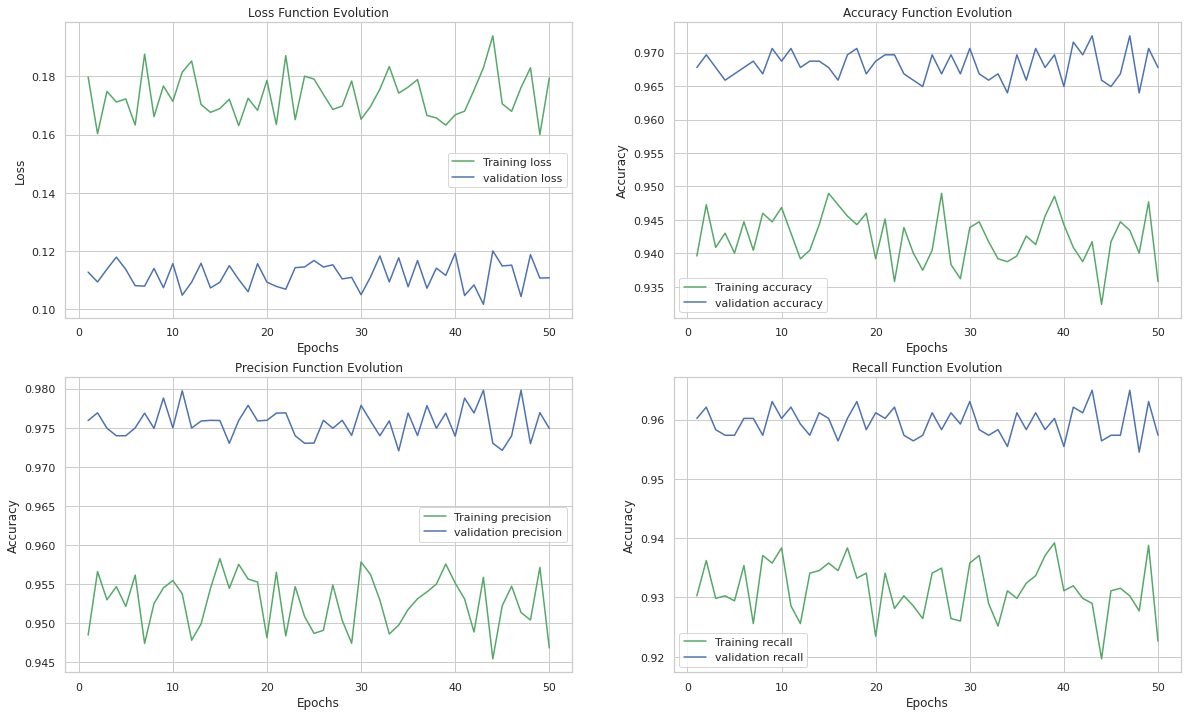

In [ ]:
evolution(model4_history,50)

In [ ]:
model4_resnet.save('model4_resnet.h5')
model4_resnet.save_weights('model4_resnet_weights.h5')

# 4.6 Transfer Learning with Xception [Model 4]

In [ ]:
from tensorflow.keras.applications import Xception

base_modelXception = Xception(input_shape = (img_height,img_width,num_channels),
                   weights='imagenet',
                   include_top=False)

image_batch, labels_batch = next(iter(train_ds))
feature_batch = base_modelXception(image_batch)
print('Feature Batch shape:', feature_batch.shape)

base_modelXception.trainable = False

global_average_layer = GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print('Feature Batch average shape:', feature_batch_average.shape)

prediction_layer = Dense(num_classes, 'softmax')
prediction_batch = prediction_layer(feature_batch_average)
print('Prediction Batch shape:', prediction_batch.shape)

inputs = Input(shape=(img_height, img_width, num_channels))
x = augment(inputs)
x = rescale(x)
x = base_modelXception(x, training=False)
x = global_average_layer(x)
x = Dropout(0.3)(x)

outputs = prediction_layer(x)

model5_Xception = Model(inputs, outputs)

model5_Xception.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics= metrics)

model5_history = model5_Xception.fit(
    train_ds,
    validation_data=val_ds,
    epochs=50,
    callbacks = [learning_rate_reduction],
)

83683744 [==============================] - 0s 0us/step
83697664/
83683744 [==============================] - 0s 0us/step
Cleanup c
74/74 [==============================] - 25s 283ms/step - loss: 0.9442 - accuracy: 0.6662 - precision: 0.9249 - recall: 0.5709 - val_loss: 0.5936 - val_accuracy: 0.8322 - val_precision: 0.9177 - val_recall: 0.6872

74/74 [==============================] - 22s 278ms/step - loss: 0.5178 - accuracy: 0.8295 - precision: 0.9009 - recall: 0.7347 - val_loss: 0.4614 - val_accuracy: 0.8569 - val_precision: 0.9184 - val_recall: 0.7791

74/74 [==============================] - 21s 266ms/step - loss: 0.4479 - accuracy: 0.8491 - precision: 0.9130 - recall: 0.7857 - val_loss: 0.3856 - val_accuracy: 0.8844 - val_precision: 0.9192 - val_recall: 0.8303

74/74 [==============================] - 20s 263ms/step - loss: 0.3980 - accuracy: 0.8682 - precision: 0.9144 - recall: 0.8125 - val_loss: 0.3522 - val_accuracy: 0.8929 - val_precision: 0.9203 - val_recall: 0.8427

74/74 [==============================] - 20s 252ms/step - loss: 0.3701 - accuracy: 0.8780 - precision: 0.9190 - recall: 0.8346 - val_loss: 0.3066 - val_accuracy: 0.9090 - val_precision: 0.9350 - val_recall: 0.8730

74/74 [==============================] - 21s 261ms/step - loss: 0.3502 - accuracy: 0.8818 - precision: 0.9186 - recall: 0.8401 - val_loss: 0.3013 - val_accuracy: 0.9081 - val_precision: 0.9290 - val_recall: 0.8682

74/74 [==============================] - 20s 259ms/step - loss: 0.3404 - accuracy: 0.8827 - precision: 0.9225 - recall: 0.8503 - val_loss: 0.3036 - val_accuracy: 0.9100 - val_precision: 0.9247 - val_recall: 0.8730

74/74 [==============================] - 20s 262ms/step - loss: 0.3127 - accuracy: 0.8958 - precision: 0.9230 - recall: 0.8614 - val_loss: 0.2880 - val_accuracy: 0.9109 - val_precision: 0.9264 - val_recall: 0.8834

74/74 [==============================] - 21s 264ms/step - loss: 0.3229 - accuracy: 0.8912 - precision: 0.9227 - recall: 0.8622 - val_loss: 0.2851 - val_accuracy: 0.9118 - val_precision: 0.9266 - val_recall: 0.8853

74/74 [==============================] - 21s 259ms/step - loss: 0.3171 - accuracy: 0.8912 - precision: 0.9218 - recall: 0.8618 - val_loss: 0.2770 - val_accuracy: 0.9100 - val_precision: 0.9321 - val_recall: 0.8853

74/74 [==============================] - 20s 253ms/step - loss: 0.2941 - accuracy: 0.9014 - precision: 0.9255 - recall: 0.8767 - val_loss: 0.2525 - val_accuracy: 0.9232 - val_precision: 0.9416 - val_recall: 0.9014

74/74 [==============================] - 21s 265ms/step - loss: 0.2894 - accuracy: 0.8975 - precision: 0.9230 - recall: 0.8669 - val_loss: 0.2552 - val_accuracy: 0.9175 - val_precision: 0.9332 - val_recall: 0.9005

74/74 [==============================] - 20s 255ms/step - loss: 0.2860 - accuracy: 0.9022 - precision: 0.9283 - recall: 0.8805 - val_loss: 0.2366 - val_accuracy: 0.9213 - val_precision: 0.9446 - val_recall: 0.9043

74/74 [==============================] - 21s 265ms/step - loss: 0.2833 - accuracy: 0.9069 - precision: 0.9285 - recall: 0.8780 - val_loss: 0.2620 - val_accuracy: 0.9137 - val_precision: 0.9287 - val_recall: 0.9014

74/74 [==============================] - 20s 257ms/step - loss: 0.2774 - accuracy: 0.9077 - precision: 0.9306 - recall: 0.8831 - val_loss: 0.2570 - val_accuracy: 0.9204 - val_precision: 0.9334 - val_recall: 0.9033

74/74 [==============================] - 20s 260ms/step - loss: 0.2715 - accuracy: 0.9031 - precision: 0.9308 - recall: 0.8801 - val_loss: 0.2590 - val_accuracy: 0.9175 - val_precision: 0.9314 - val_recall: 0.9014

74/74 [==============================] - 20s 257ms/step - loss: 0.2648 - accuracy: 0.9086 - precision: 0.9338 - recall: 0.8873 - val_loss: 0.2453 - val_accuracy: 0.9242 - val_precision: 0.9363 - val_recall: 0.9062

74/74 [==============================] - 20s 252ms/step - loss: 0.2588 - accuracy: 0.9154 - precision: 0.9362 - recall: 0.8929 - val_loss: 0.2560 - val_accuracy: 0.9185 - val_precision: 0.9350 - val_recall: 0.9005

74/74 [==============================] - 21s 268ms/step - loss: 0.2672 - accuracy: 0.9107 - precision: 0.9332 - recall: 0.8903 - val_loss: 0.2459 - val_accuracy: 0.9223 - val_precision: 0.9382 - val_recall: 0.9071

74/74 [==============================] - 20s 257ms/step - loss: 0.2566 - accuracy: 0.9128 - precision: 0.9378 - recall: 0.8903 - val_loss: 0.2564 - val_accuracy: 0.9156 - val_precision: 0.9296 - val_recall: 0.9014

74/74 [==============================] - 21s 266ms/step - loss: 0.2661 - accuracy: 0.9137 - precision: 0.9381 - recall: 0.8895 - val_loss: 0.2527 - val_accuracy: 0.9185 - val_precision: 0.9344 - val_recall: 0.9043

74/74 [==============================] - 20s 251ms/step - loss: 0.2769 - accuracy: 0.9060 - precision: 0.9297 - recall: 0.8771 - val_loss: 0.2478 - val_accuracy: 0.9156 - val_precision: 0.9323 - val_recall: 0.9005

74/74 [==============================] - 20s 254ms/step - loss: 0.2773 - accuracy: 0.9094 - precision: 0.9320 - recall: 0.8861 - val_loss: 0.2478 - val_accuracy: 0.9194 - val_precision: 0.9363 - val_recall: 0.9052

74/74 [==============================] - 20s 258ms/step - loss: 0.2655 - accuracy: 0.9077 - precision: 0.9343 - recall: 0.8822 - val_loss: 0.2460 - val_accuracy: 0.9223 - val_precision: 0.9354 - val_recall: 0.9062

74/74 [==============================] - 20s 258ms/step - loss: 0.2711 - accuracy: 0.9035 - precision: 0.9261 - recall: 0.8788 - val_loss: 0.2596 - val_accuracy: 0.9147 - val_precision: 0.9302 - val_recall: 0.8967

74/74 [==============================] - 21s 267ms/step - loss: 0.2626 - accuracy: 0.9124 - precision: 0.9322 - recall: 0.8890 - val_loss: 0.2580 - val_accuracy: 0.9194 - val_precision: 0.9344 - val_recall: 0.9052

74/74 [==============================] - 20s 255ms/step - loss: 0.2632 - accuracy: 0.9111 - precision: 0.9405 - recall: 0.8869 - val_loss: 0.2450 - val_accuracy: 0.9194 - val_precision: 0.9352 - val_recall: 0.9024

74/74 [==============================] - 21s 268ms/step - loss: 0.2727 - accuracy: 0.9009 - precision: 0.9267 - recall: 0.8767 - val_loss: 0.2476 - val_accuracy: 0.9204 - val_precision: 0.9335 - val_recall: 0.9052

74/74 [==============================] - 20s 260ms/step - loss: 0.2697 - accuracy: 0.9022 - precision: 0.9275 - recall: 0.8805 - val_loss: 0.2480 - val_accuracy: 0.9223 - val_precision: 0.9346 - val_recall: 0.9071

74/74 [==============================] - 20s 253ms/step - loss: 0.2678 - accuracy: 0.9137 - precision: 0.9402 - recall: 0.8895 - val_loss: 0.2475 - val_accuracy: 0.9185 - val_precision: 0.9332 - val_recall: 0.9005

74/74 [==============================] - 21s 265ms/step - loss: 0.2536 - accuracy: 0.9158 - precision: 0.9438 - recall: 0.8929 - val_loss: 0.2496 - val_accuracy: 0.9185 - val_precision: 0.9325 - val_recall: 0.9033

74/74 [==============================] - 21s 266ms/step - loss: 0.2595 - accuracy: 0.9175 - precision: 0.9367 - recall: 0.8933 - val_loss: 0.2578 - val_accuracy: 0.9166 - val_precision: 0.9323 - val_recall: 0.9005

74/74 [==============================] - 21s 267ms/step - loss: 0.2718 - accuracy: 0.9099 - precision: 0.9338 - recall: 0.8869 - val_loss: 0.2404 - val_accuracy: 0.9232 - val_precision: 0.9385 - val_recall: 0.9109

74/74 [==============================] - 20s 253ms/step - loss: 0.2562 - accuracy: 0.9133 - precision: 0.9361 - recall: 0.8907 - val_loss: 0.2506 - val_accuracy: 0.9185 - val_precision: 0.9334 - val_recall: 0.9033

74/74 [==============================] - 21s 261ms/step - loss: 0.2543 - accuracy: 0.9128 - precision: 0.9341 - recall: 0.8856 - val_loss: 0.2379 - val_accuracy: 0.9261 - val_precision: 0.9404 - val_recall: 0.9118

74/74 [==============================] - 20s 259ms/step - loss: 0.2681 - accuracy: 0.9086 - precision: 0.9319 - recall: 0.8848 - val_loss: 0.2604 - val_accuracy: 0.9109 - val_precision: 0.9264 - val_recall: 0.8948

74/74 [==============================] - 20s 256ms/step - loss: 0.2526 - accuracy: 0.9235 - precision: 0.9420 - recall: 0.8984 - val_loss: 0.2493 - val_accuracy: 0.9166 - val_precision: 0.9315 - val_recall: 0.9024

74/74 [==============================] - 21s 266ms/step - loss: 0.2918 - accuracy: 0.9018 - precision: 0.9261 - recall: 0.8737 - val_loss: 0.2451 - val_accuracy: 0.9204 - val_precision: 0.9346 - val_recall: 0.9071

74/74 [==============================] - 21s 263ms/step - loss: 0.2719 - accuracy: 0.9073 - precision: 0.9296 - recall: 0.8873 - val_loss: 0.2519 - val_accuracy: 0.9213 - val_precision: 0.9342 - val_recall: 0.9024

74/74 [==============================] - 20s 263ms/step - loss: 0.2578 - accuracy: 0.9213 - precision: 0.9445 - recall: 0.8975 - val_loss: 0.2428 - val_accuracy: 0.9223 - val_precision: 0.9364 - val_recall: 0.9071

74/74 [==============================] - 20s 249ms/step - loss: 0.2679 - accuracy: 0.9048 - precision: 0.9279 - recall: 0.8805 - val_loss: 0.2531 - val_accuracy: 0.9147 - val_precision: 0.9304 - val_recall: 0.8995

74/74 [==============================] - 21s 263ms/step - loss: 0.2604 - accuracy: 0.9086 - precision: 0.9352 - recall: 0.8839 - val_loss: 0.2406 - val_accuracy: 0.9242 - val_precision: 0.9393 - val_recall: 0.9100

74/74 [==============================] - 21s 267ms/step - loss: 0.2607 - accuracy: 0.9158 - precision: 0.9367 - recall: 0.8933 - val_loss: 0.2473 - val_accuracy: 0.9204 - val_precision: 0.9400 - val_recall: 0.9062

74/74 [==============================] - 20s 259ms/step - loss: 0.2628 - accuracy: 0.9167 - precision: 0.9353 - recall: 0.8916 - val_loss: 0.2538 - val_accuracy: 0.9175 - val_precision: 0.9323 - val_recall: 0.9005

74/74 [==============================] - 21s 265ms/step - loss: 0.2666 - accuracy: 0.9094 - precision: 0.9379 - recall: 0.8856 - val_loss: 0.2566 - val_accuracy: 0.9128 - val_precision: 0.9300 - val_recall: 0.8948

74/74 [==============================] - 20s 254ms/step - loss: 0.2622 - accuracy: 0.9111 - precision: 0.9343 - recall: 0.8827 - val_loss: 0.2465 - val_accuracy: 0.9194 - val_precision: 0.9316 - val_recall: 0.9033

74/74 [==============================] - 20s 258ms/step - loss: 0.2595 - accuracy: 0.9099 - precision: 0.9326 - recall: 0.8827 - val_loss: 0.2484 - val_accuracy: 0.9194 - val_precision: 0.9334 - val_recall: 0.9033

74/74 [==============================] - 21s 264ms/step - loss: 0.2686 - accuracy: 0.9073 - precision: 0.9279 - recall: 0.8814 - val_loss: 0.2468 - val_accuracy: 0.9223 - val_precision: 0.9363 - val_recall: 0.9052

74/74 [==============================] - 20s 258ms/step - loss: 0.2729 - accuracy: 0.9039 - precision: 0.9286 - recall: 0.8793 - val_loss: 0.2559 - val_accuracy: 0.9175 - val_precision: 0.9305 - val_recall: 0.9005

74/74 [==============================] - 21s 266ms/step - loss: 0.2589 - accuracy: 0.9171 - precision: 0.9384 - recall: 0.8937 - val_loss: 0.2479 - val_accuracy: 0.9185 - val_precision: 0.9342 - val_recall: 0.9014

In [ ]:
model5_Xception.save('model5_Xception.h5')
model5_Xception.save_weights('model5_Xception_weights.h5')

()

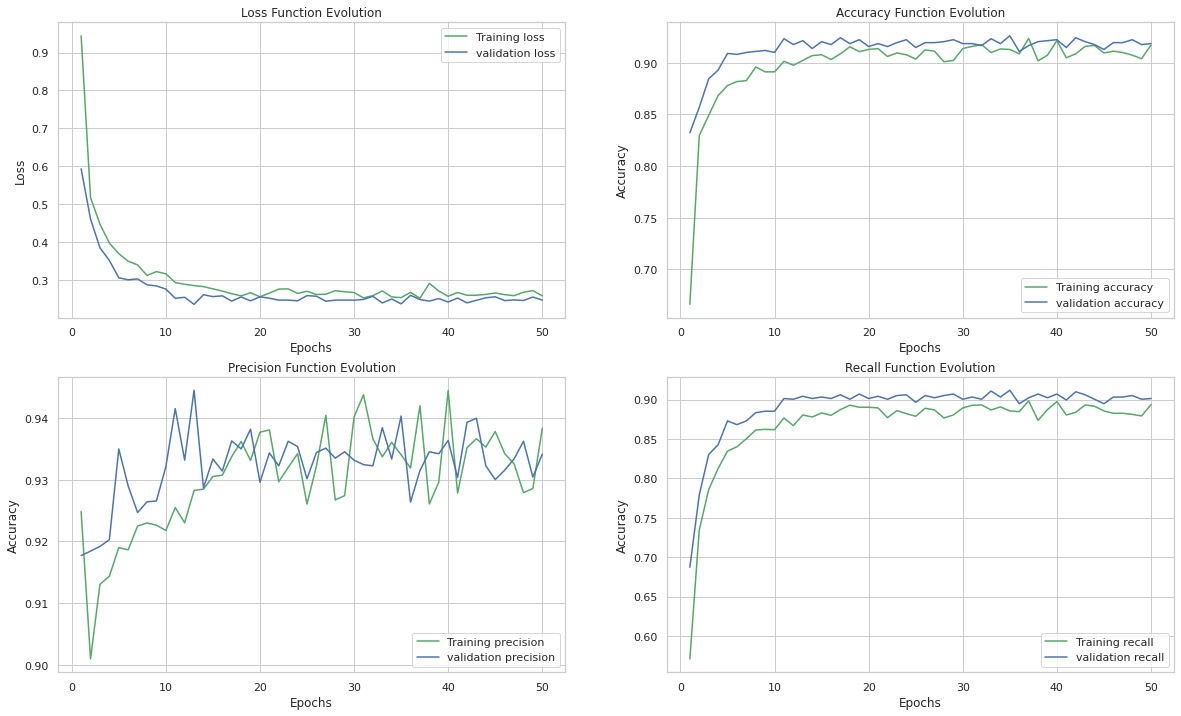

In [ ]:
evolution(model5_history,50)

### Dari hasil evaluasi model pada Tabel 1 terlihat bahwa model MobileNetV2 memiliki training accuracy paling tinggi diantara model-model yang lain yaitu 0,96, disusul dengan akurasi dari Resnet50 yang berbeda tipis yaitu dengan angka 0,95%. Tetapi untuk validation accuaracy Resnet50 lebih unggul dibandingkan dengan MobileNetV2 yaitu pada angka 0,97

# 5. MAKING RECOGNITION PREDIKSI.

## 5.1 Prediksi Resnet50

In [ ]:
from tensorflow.keras.models import load_model

In [ ]:
model_resnet = load_model('model4_resnet.h5')

In [ ]:
for images, labels in test_ds.take(1):
  for i in range(9):
    img_array = images[i].numpy().astype("uint8")
    img_array = tf.expand_dims(img_array, 0) # Create a batch
    
    predictions = model_resnet.predict(img_array)
    score = tf.nn.softmax(predictions[0])
    
    print('Actual class:', class_names[np.argmax(labels[i])], '|| Predicted class: {}; with a {:.2f} percent confidence.'
          .format(class_names[np.argmax(score)], 100 * np.max(score)),'\n')

Actual class: tongkonan || Predicted class: tongkonan; with a 40.45 percent confidence. 

Actual class: gadang || Predicted class: joglo; with a 29.43 percent confidence. 

Actual class: gadang || Predicted class: gadang; with a 40.37 percent confidence. 

Actual class: tongkonan || Predicted class: tongkonan; with a 36.94 percent confidence. 

Actual class: honai || Predicted class: honai; with a 40.46 percent confidence. 

Actual class: tongkonan || Predicted class: tongkonan; with a 38.62 percent confidence. 

Actual class: gadang || Predicted class: gadang; with a 40.33 percent confidence. 

Actual class: tongkonan || Predicted class: tongkonan; with a 38.45 percent confidence. 

Actual class: tongkonan || Predicted class: tongkonan; with a 39.66 percent confidence. 

## 5.2. MobileNet V2

In [ ]:
model_renet = load_model('model2_mobileNet.h5')
for images, labels in test_ds.take(1):
  for i in range(9):
    img_array = images[i].numpy().astype("uint8")
    img_array = tf.expand_dims(img_array, 0) # Create a batch
    
    predictions = model_resnet.predict(img_array)
    score = tf.nn.softmax(predictions[0])
    
    print('Actual class:', class_names[np.argmax(labels[i])], '|| Predicted class: {}; with a {:.2f} percent confidence.'
          .format(class_names[np.argmax(score)], 100 * np.max(score)),'\n')

Actual class: honai || Predicted class: honai; with a 40.42 percent confidence. 

Actual class: tongkonan || Predicted class: tongkonan; with a 40.46 percent confidence. 

Actual class: gadang || Predicted class: gadang; with a 34.96 percent confidence. 

Actual class: gadang || Predicted class: gadang; with a 40.46 percent confidence. 

Actual class: tongkonan || Predicted class: tongkonan; with a 40.20 percent confidence. 

Actual class: gadang || Predicted class: gadang; with a 32.19 percent confidence. 

Actual class: gadang || Predicted class: gadang; with a 40.41 percent confidence. 

Actual class: panjang || Predicted class: panjang; with a 40.37 percent confidence. 

Actual class: panjang || Predicted class: panjang; with a 40.40 percent confidence.

## 5.3 VGG16

In [ ]:
model_renet = load_model('model3_VGG16.h5')
for images, labels in test_ds.take(1):
  for i in range(9):
    img_array = images[i].numpy().astype("uint8")
    img_array = tf.expand_dims(img_array, 0) # Create a batch
    
    predictions = model_resnet.predict(img_array)
    score = tf.nn.softmax(predictions[0])
    
    print('Actual class:', class_names[np.argmax(labels[i])], '|| Predicted class: {}; with a {:.2f} percent confidence.'
          .format(class_names[np.argmax(score)], 100 * np.max(score)),'\n')

Actual class: gadang || Predicted class: gadang; with a 40.35 percent confidence. 

Actual class: joglo || Predicted class: honai; with a 32.27 percent confidence. 

Actual class: tongkonan || Predicted class: tongkonan; with a 40.33 percent confidence. 

Actual class: gadang || Predicted class: gadang; with a 40.42 percent confidence. 

Actual class: panjang || Predicted class: panjang; with a 40.16 percent confidence. 

Actual class: panjang || Predicted class: panjang; with a 39.67 percent confidence. 

Actual class: gadang || Predicted class: gadang; with a 40.45 percent confidence. 

Actual class: tongkonan || Predicted class: tongkonan; with a 40.46 percent confidence. 

Actual class: gadang || Predicted class: gadang; with a 40.41 percent confidence.

## 5.4 Xception

In [ ]:
model_renet = load_model('model5_Xception.h5')
for images, labels in test_ds.take(1):
  for i in range(9):
    img_array = images[i].numpy().astype("uint8")
    img_array = tf.expand_dims(img_array, 0) # Create a batch
    
    predictions = model_resnet.predict(img_array)
    score = tf.nn.softmax(predictions[0])
    
    print('Actual class:', class_names[np.argmax(labels[i])], '|| Predicted class: {}; with a {:.2f} percent confidence.'
          .format(class_names[np.argmax(score)], 100 * np.max(score)),'\n')

Actual class: panjang || Predicted class: panjang; with a 39.69 percent confidence. 

Actual class: tongkonan || Predicted class: tongkonan; with a 40.43 percent confidence. 

Actual class: joglo || Predicted class: honai; with a 30.09 percent confidence. 

Actual class: gadang || Predicted class: gadang; with a 37.25 percent confidence. 

Actual class: honai || Predicted class: honai; with a 39.10 percent confidence. 

Actual class: honai || Predicted class: honai; with a 40.40 percent confidence. 

Actual class: panjang || Predicted class: panjang; with a 40.15 percent confidence. 

Actual class: gadang || Predicted class: gadang; with a 37.90 percent confidence. 

Actual class: tongkonan || Predicted class: tongkonan; with a 38.16 percent confidence.